In [143]:
import os

import scipy.io as sio
from scipy.io import readsav
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import emcee
from astropy.io import fits
from collections import Counter
import radvel

from residual_plot import residual_plot
from Weighted_LS_crossval_fit import Weighted_LS_crossval_fit
from overfitting_checks import overfitting_checks
from Weighted_LS_fit import Weighted_LS_fit
from Weighted_LS_fit_with_h_alpha import Weighted_LS_fit_with_h_alpha
from results_compare_ccf_plot import results_compare_ccf_plot
from Weighted_LS_fit_with_h_alpha_AND_planet import Weighted_LS_fit_with_h_alpha_AND_planet

plt.rcParams['font.size'] = 15

In [179]:
star_name = '34411' #'10700'#'101501'#34411# '26965'
file_end = 'prov_rvs' #"best_fit" #"prov_rvs"#or 

hdul_open = fits.open('HD'+star_name+'/shifted_ccfs/shifted_ccfs_combined_'+file_end+'_with_s_halpha.fits', memmap=False)
wls = hdul_open[1].data['wls']

ccf_list = hdul_open[1].data['norm_shifted_ccf']

ccf_list = ccf_list - np.median(ccf_list, axis=0)
median_residual = np.median(ccf_list, axis=0)
std_residual = np.std(ccf_list, axis=0)
rescaled_resids = (ccf_list-median_residual)/std_residual

bjd_list = hdul_open[2].data['bjd']#[8:]

if file_end =="best_fit":
    rv_list = hdul_open[2].data['mu_og_list']
else:
    rv_list = hdul_open[2].data['vrad_star']


# pull coefficients from csv's
binned_results = pd.read_csv('HD'+star_name+'/'+'binned_coeffs/coeff'+star_name+"_"+file_end+'June11.csv') 
ccf_indexes = binned_results["ccf_indexes"]
a_coeff = binned_results["a_coeff"]
    
#rv_list = hdul_open[2].data['vrad_star']# hdul_open[2].data['mu_og_list'] # [8:] #hdul_open[2].data['mu_og_list'][8:] #
rv_error = hdul_open[2].data['svrad_star']#[8:]
h_alpha = hdul_open[2].data['h_alpha']

# create pandas dataframe
df = pd.DataFrame(list(zip(bjd_list, rv_list, rv_error, h_alpha, rescaled_resids)), 
                  columns=["BJD","vrad", "svrad","h_alpha", "CCF"])
df_sorted = df.sort_values(by=['BJD']) 

In [180]:
ccf_indexes = [int(x) for x in ccf_indexes[0].replace('[', '').replace(']', '').split(",")]
a_coeff = [float(x) for x in a_coeff[0].replace('[', '').replace(']', '').split()]

ccf_indexes

[334, 356, 394, 409, 433]

In [181]:
# format data for LS fit
rv_np = np.array(list(df_sorted["vrad"]-np.mean(df_sorted["vrad"])))*1000
s_rv_np = np.array(list(df_sorted["svrad"]))*1000
h_alpha_np = np.array([list(df_sorted["h_alpha"]-np.mean(df_sorted["h_alpha"]))])*1000
ccf_list_np = np.array(list(df_sorted["CCF"]))
ccf_list_np_transpose = ccf_list_np.transpose()
ccf_list_np_transpose_extra_info = np.append(ccf_list_np_transpose, h_alpha_np, axis=0)

time_np = np.array(df_sorted["BJD"])-np.min(df_sorted["BJD"])

Text(0, 0.5, 'RV (m/s)')

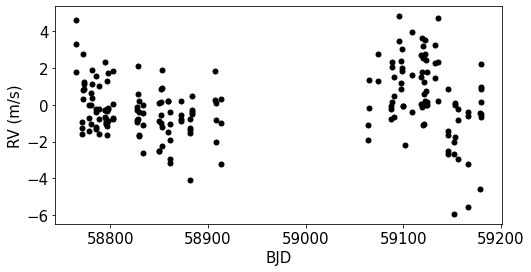

In [182]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

x = df_sorted["BJD"]
y = rv_np
yerr = df_sorted["svrad"]

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax.errorbar(x, y, yerr = yerr, fmt = 'o', color='k')
ax.set_xlabel("BJD", size=15)
ax.set_ylabel("RV (m/s)",size=15)

0.0 1.0


[334, 356, 394, 409, 433]

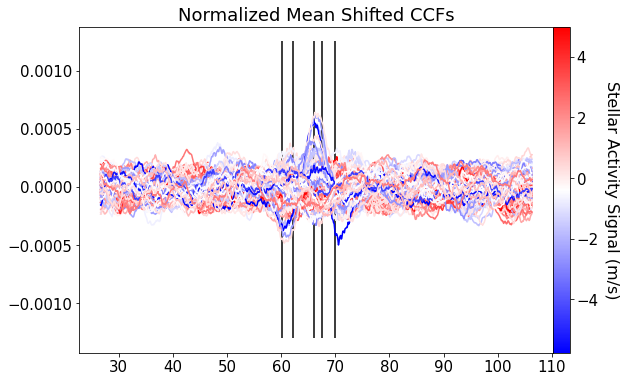

In [183]:
residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.0013, ymax=0.00125, color="k")
ccf_indexes

50
50


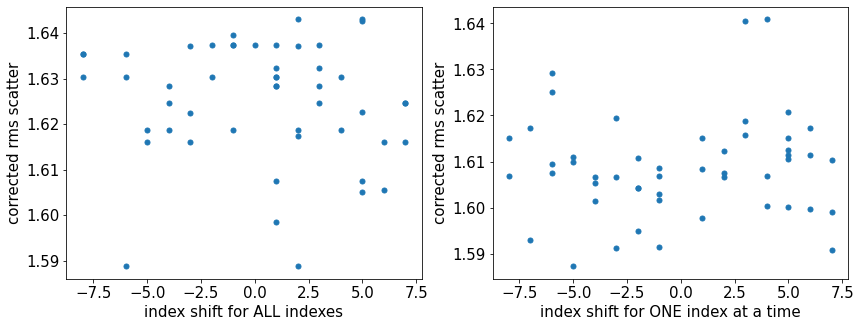

In [184]:
# Quick overfitting check

num_runs= 50
overfitting_checks(num_runs, ccf_indexes, ccf_list_np, ccf_list_np_transpose, rv_np, s_rv_np)

1.5886965492008196

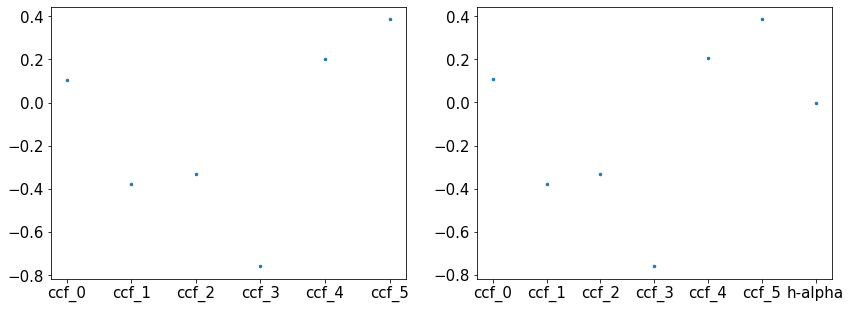

In [185]:
# run the LS fits

#first run the fit WITHOUT s-index, h-alpha
a_coeff, y_preds, CCF_matrix, raw_rms, ccf_corr_rms = Weighted_LS_fit(ccf_indexes, ccf_list_np, 
                                                     ccf_list_np_transpose,rv_np, s_rv_np)

# Now, run the weighted LS fit WITH h-alpha, s-index, BIS
a_coeff_hsb, y_preds_hsb, CCF_matrix_hsb, raw_rms_hsb, ccf_corr_rms_hsb = Weighted_LS_fit_with_h_alpha(ccf_indexes, 
                                                                          ccf_list_np, ccf_list_np_transpose_extra_info,
                                                                          rv_np, s_rv_np)
# create a list of coeff names for plotting
coeff_names = []
for i in np.arange(0, len(a_coeff)):
    coeff_names.append("ccf_"+str(i))
    
coeff_names_hsb = coeff_names.copy()
coeff_names_hsb.append("h-alpha")

fig, ax = plt.subplots(1,2, figsize=(14, 5))
ax[0].plot(coeff_names, a_coeff, ".")
ax[1].plot(coeff_names_hsb, a_coeff_hsb, ".")
ccf_corr_rms


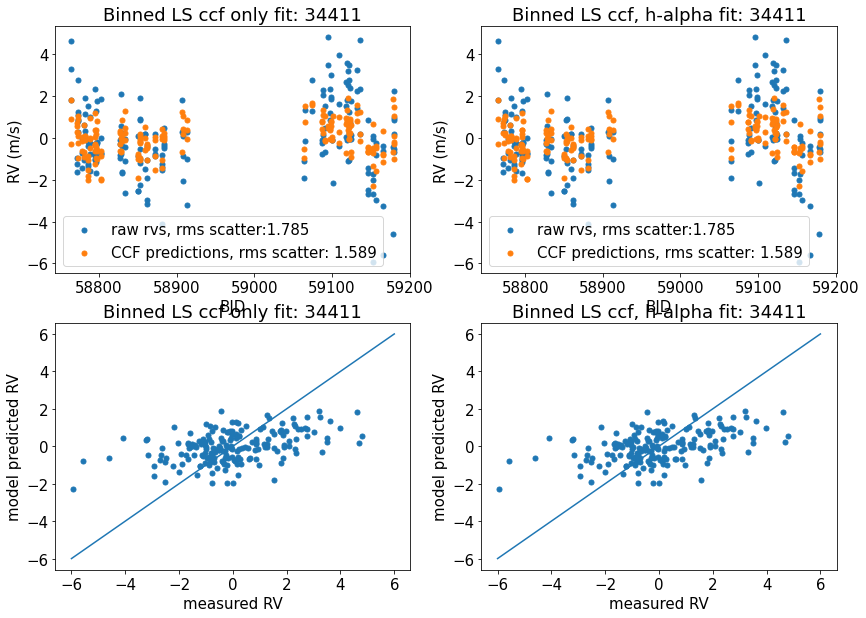

In [186]:
# plot the results from using only the ccf versus using the ccf+s-index+h-alpha 
results_compare_ccf_plot(df_sorted["BJD"], y, y_preds, raw_rms, ccf_corr_rms, 
                         y_preds_hsb, ccf_corr_rms_hsb, star_name)

In [187]:
# create dataframe to write ccf only results to a csv
nan_array = np.empty((1,len(df_sorted["BJD"])))
nan_array[:] = np.NaN

df_results = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-y_preds,nan_array[0], 
                                   y_preds, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/')

if file_end == 'prov_rvs':
    full_ending = file_end+'_cbc_rvs'
else:
    full_ending = file_end+'_gauss'
    
# write results to a file 
df_results.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'+star_name+"_ML_EPRVs_CCFLinearRegression_"+full_ending+'.csv', index=False)

#-----------------------------------------------------------------------------

# create dataframe to write ccf, s-index, h-alpha results to a csv
df_results_hsb = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-y_preds_hsb,nan_array[0], 
                                   y_preds_hsb, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/')

if file_end == 'prov_rvs':
    full_ending = file_end+'_cbc_rvs'
else:
    full_ending = file_end+'_gauss'
    
# write results to a file 
df_results_hsb.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'+star_name+"_ML_EPRVs_CCF_h-alpha_LinearRegression_"+full_ending+'.csv', index=False)

In [188]:
# Check file contents
pd_read= pd.read_csv('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'+star_name+"_ML_EPRVs_CCF_h-alpha_LinearRegression_"+full_ending+'.csv') 
pd_read[0:10]

,Time [MJD],RV_C [m/s],e_RV_C [m/s],RV_A [m/s],e_RV_A [m/s]
0,58764.476562,3.605395,NaN,-0.305641,NaN
1,58764.476562,0.910644,NaN,0.893748,NaN
2,58764.480469,2.801975,NaN,1.825294,NaN
3,58771.414062,-1.526206,NaN,0.263581,NaN
4,58771.417969,-2.314727,NaN,0.708780,NaN
5,58771.417969,-1.517303,NaN,0.582743,NaN
6,58772.472656,1.862737,NaN,0.902959,NaN
7,58772.476562,1.262241,NaN,-0.976098,NaN
8,58772.476562,1.034639,NaN,-0.229697,NaN
9,58773.453125,1.140855,NaN,0.121850,NaN


## Stop here. You are done.

## Code to find the planet in HD 26965

planet K = 2.8830899439785593 m/s


2.7109617664607772

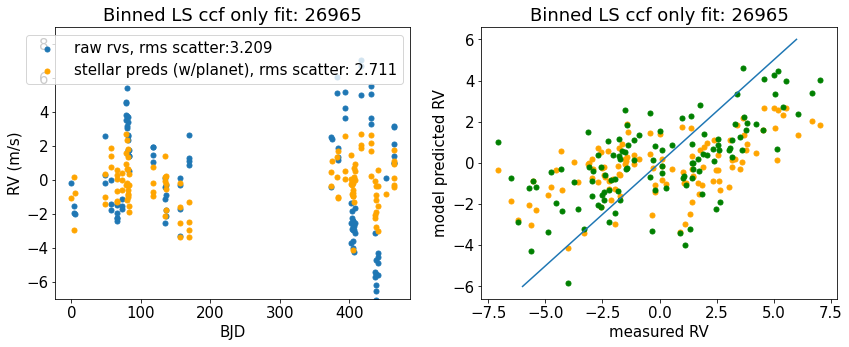

In [140]:
orbel = [42.378, -52828.72828125, 0.04, 2.6, 1.0]

# Now, run the weighted LS fit WITH h-alpha AND Planet Signal
a_coeff_h_pl, y_preds_h_pl, CCF_matrix_h_pl, raw_rms_h_pl, ccf_corr_rms_h_pl = Weighted_LS_fit_with_h_alpha_AND_planet(ccf_indexes, 
                                                                          ccf_list_np, ccf_list_np_transpose_extra_info,
                                                                          rv_np, s_rv_np, time_np, orbel)

stellar_preds = CCF_matrix_h_pl[:,1:].dot(a_coeff_h_pl[1:])
corrected_RVs = y - stellar_preds
uncorrected_RVs = y


fig, ax = plt.subplots(1,2, figsize=(14, 5))
#first plot the ccf-only results
ax[0].scatter(time_np,
                  y, label="raw rvs, rms scatter:"+str(round(raw_rms,3)))
ax[0].scatter(time_np,
                  stellar_preds, label="stellar preds (w/planet), rms scatter: "+str(round(np.std(corrected_RVs),3)), color='orange')
#ax[0].scatter(time_np,
#                  y_preds_hsb, label="stellar preds (NO planet), rms scatter: "+str(round(np.std(y-y_preds_hsb),3)), color='green')
ax[0].set_ylabel("RV (m/s)")
ax[0].set_xlabel("BJD")
ax[0].set_title("Binned LS ccf only fit: "+star_name)
ax[0].set_ylim(-7, 9)
ax[0].legend()

ax[1].scatter(y, stellar_preds, color='orange')
ax[1].scatter(y, y_preds_hsb, color='green')
ax[1].plot([-6,6],[-6,6])
ax[1].set_xlabel("measured RV")
ax[1].set_ylabel("model predicted RV")
ax[1].set_title("Binned LS ccf only fit: "+star_name)
    
print("planet K = "+str(a_coeff_h_pl[0])+" m/s")
np.std(corrected_RVs)

In [141]:
# Write this solution to a csv file (WITHOUT subtracting the planet signal)

nan_array = np.empty((1,len(df_sorted["BJD"])))
nan_array[:] = np.NaN

df_results = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-stellar_preds,nan_array[0], 
                                   stellar_preds, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/')

if file_end == 'prov_rvs':
    full_ending = file_end+'_cbc_rvs'
else:
    full_ending = file_end+'_gauss'
    
# write results to a file 
df_results.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'+star_name+'_ML_EPRVs_CCF_h-alpha_keplerian_LinearRegression_'+full_ending+'.csv', index=False)

In [142]:
# Check file contents
pd_read= pd.read_csv('HD'+star_name+'/'+'ML_EPRVs_results/unbinned/'+star_name+'_ML_EPRVs_CCF_h-alpha_keplerian_LinearRegression_'+full_ending+'.csv') 
pd_read

,Time [MJD],RV_C [m/s],e_RV_C [m/s],RV_A [m/s],e_RV_A [m/s]
0,58715.488281,0.905479,NaN,-1.087949,NaN
1,58719.468750,1.039531,NaN,-2.969132,NaN
2,58719.472656,-1.709428,NaN,0.188000,NaN
3,58720.496094,-1.259585,NaN,-0.761569,NaN
4,58764.398438,1.196017,NaN,-1.401375,NaN
...,...,...,...,...,...
109,59179.335938,2.004334,NaN,1.101466,NaN
110,59179.335938,3.033032,NaN,0.126173,NaN
111,59180.226562,-0.774746,NaN,1.740501,NaN
112,59180.230469,1.449844,NaN,-0.442128,NaN


## Older code (before June, 2021)

0.0 1.0
--------
1.6371422211103472


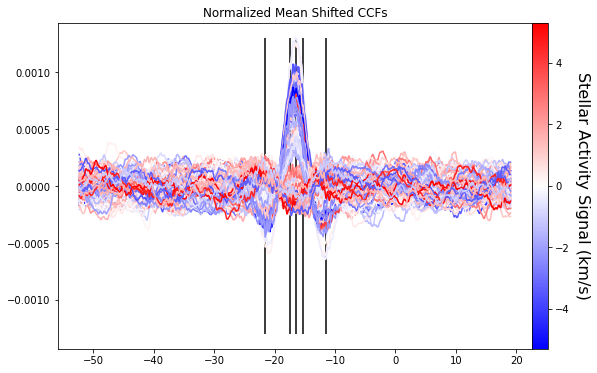

In [36]:
# perform weighted cross-validation

y_val_preds_list, raw_val_rms, new_val_rms, new_train_rms_list, a_coeff_list = Weighted_LS_crossval_fit(ccf_indexes, ccf_list_np, rv_np, s_rv_np)

residual_plot(rv_np, wls[0], ccf_list, "median", plot_title = "Normalized Mean Shifted CCFs")
plt.vlines(wls[0][ccf_indexes], ymin=-0.0013, ymax=0.0013, color="k")

print("--------")
print(new_val_rms)

(-5.470559060985624, 5.736206686084688)

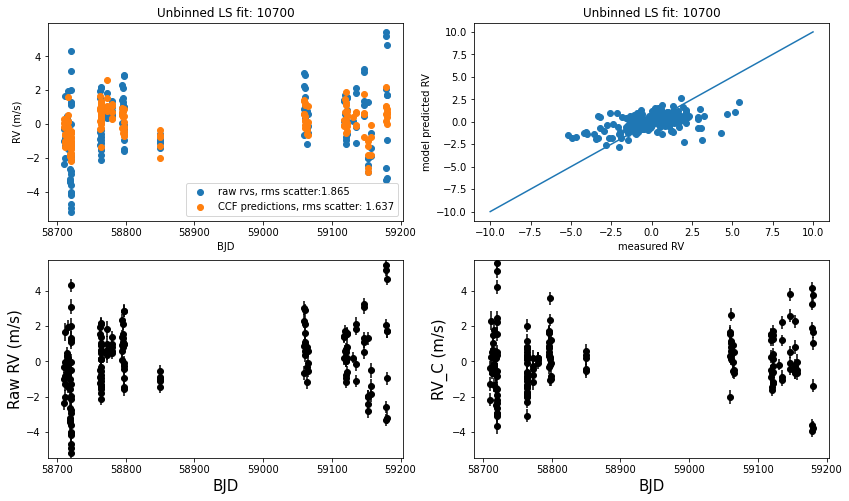

In [38]:
#plot the results
fig, ax = plt.subplots(2,2, figsize=(14, 8))
ax[0][0].scatter(time_np+np.min(df_sorted["BJD"]),
              y, label="raw rvs, rms scatter:"+str(round(raw_val_rms,3)))
ax[0][0].scatter(time_np+np.min(df_sorted["BJD"]),
              y_val_preds_list, label="CCF predictions, rms scatter: "+str(round(new_val_rms,3)))
ax[0][0].set_ylabel("RV (m/s)")
ax[0][0].set_xlabel("BJD")
ax[0][0].set_title("Unbinned LS fit: "+star_name)
ax[0][0].legend()

ax[0][1].scatter(y, y_val_preds_list)
ax[0][1].plot([-10,10],[-10,10])
ax[0][1].set_xlabel("measured RV")
ax[0][1].set_ylabel("model predicted RV")
ax[0][1].set_title("Unbinned LS fit: "+star_name)

# cleaned data plot

#fig, ax1 = plt.subplots(1,2, figsize=(14, 4))

#ax[0].scatter(txt_file["BJD_UTC"]-2400000, txt_file["vrad"]-np.mean(txt_file["vrad"]))
ax[1][0].errorbar(bjd_list, y, yerr = s_rv_np, fmt = 'o', color='k')
ax[1][0].set_xlabel("BJD", size=15)
ax[1][0].set_ylabel("Raw RV (m/s)",size=15)
ax[1][0].set_ylim(np.min(y)-0.3,np.max(y)+0.3)

ax[1][1].errorbar(bjd_list, y-y_val_preds_list, yerr = s_rv_np, fmt = 'o', color='k')
ax[1][1].set_xlabel("BJD", size=15)
ax[1][1].set_ylabel("RV_C (m/s)",size=15)
ax[1][1].set_ylim(np.min(y)-0.3,np.max(y)+0.3)

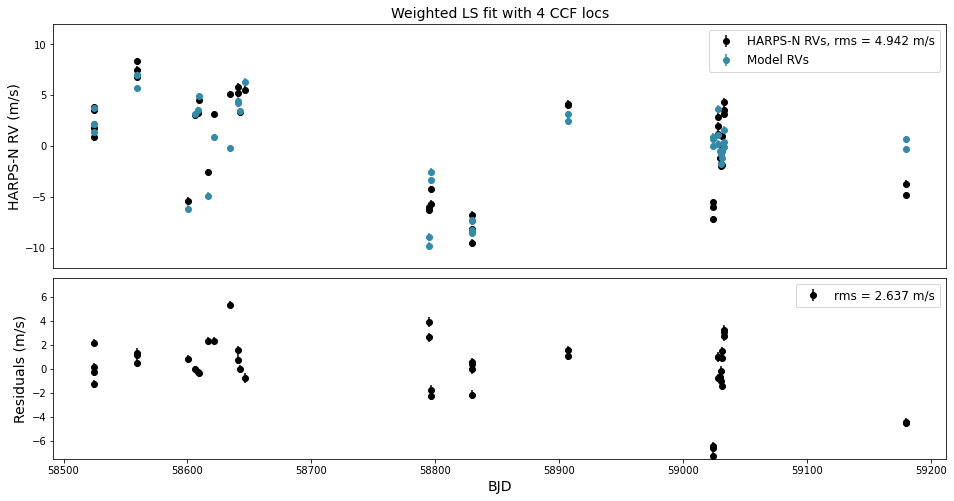

In [23]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(nrows=7, ncols=1)

# Column 1
ax0 = fig.add_subplot(gs[0:4, 0])
ax0.errorbar(time_np+np.min(df_sorted["BJD"]), y, yerr = s_rv_np, fmt = 'o', color='k', label="HARPS-N RVs, rms = "+str(round(raw_val_rms,3))+" m/s")
ax0.errorbar(time_np+np.min(df_sorted["BJD"]), y_val_preds_list, yerr = s_rv_np, fmt = 'o', color='#328ba8',label="Model RVs")
ax0.set_ylabel("HARPS-N RV (m/s)", size =14)
ax0.get_xaxis().set_visible(False)
ax0.set_ylim(-12,12)
ax0.set_title("Weighted LS fit with "+str(len(ccf_indexes))+" CCF locs", size =14)
ax0.legend(loc="upper right", fontsize=12)

ax1 = fig.add_subplot(gs[4:, 0])
ax1.errorbar(time_np+np.min(df_sorted["BJD"]), y-y_val_preds_list, yerr = s_rv_np, fmt = 'o', color='k',label="rms = "+str(round(new_val_rms, 3))+" m/s")
ax1.set_ylabel("Residuals (m/s)", size =14)
ax1.set_xlabel("BJD", size =14)
ax1.set_ylim(-7.5,7.5)
ax1.legend(loc="upper right",fontsize=12)

In [24]:
delta_RMS = raw_val_rms - new_val_rms
round(delta_RMS, 3)

2.305

In [96]:
apples_raw_rms = np.std(y)
apples_corr_rms = np.std(y_val_preds_list-y)
print("raw rms: "+str(apples_raw_rms))
print("corr rms: "+str(apples_corr_rms))

raw rms: 1.7801921824397018
corr rms: 1.694779999612736


In [83]:
apples_raw_rms-apples_corr_rms

0.02249212291016156

In [84]:
nan_array = np.empty((1,len(df_sorted["BJD"])))
nan_array[:] = np.NaN
nan_array[0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [85]:
# create dataframe to write results to a csv

df_results = pd.DataFrame(list(zip(df_sorted["BJD"], 
                                   y-y_val_preds_list,nan_array[0], 
                                   y_val_preds_list, nan_array[0])),
                        columns=["Time [MJD]",
                                 "RV_C [m/s]","e_RV_C [m/s]",
                                 "RV_A [m/s]","e_RV_A [m/s]"])

# Make directory if it does not exist
if not os.path.exists('HD'+star_name+'/'+'ML_EPRVs_results'):
    os.makedirs('HD'+star_name+'/'+'ML_EPRVs_results')

if file_end == 'prov_rvs':
    full_ending = file_end+'_cbc_rvs'
else:
    full_ending = file_end+'_gauss'
    
# write results to a file 
#df_results.to_csv('HD'+star_name+'/'+'ML_EPRVs_results/'+star_name+"_ML_EPRVs_CCFLinearRegression_"+full_ending+'.csv', index=False)

In [86]:
# Check file contents
pd_read= pd.read_csv('HD'+star_name+'/'+'ML_EPRVs_results/'+star_name+"_ML_EPRVs_CCFLinearRegression_"+full_ending+'.csv') 
pd_read

,Time [MJD],RV_C [m/s],e_RV_C [m/s],RV_A [m/s],e_RV_A [m/s]
0,58764.476562,3.454440,NaN,-0.325821,NaN
1,58764.476562,0.874635,NaN,0.438189,NaN
2,58764.480469,2.645827,NaN,0.208135,NaN
3,58771.414062,-1.984764,NaN,-0.303486,NaN
4,58771.417969,-2.484851,NaN,0.303413,NaN
...,...,...,...,...,...
183,59179.433594,0.281572,NaN,0.329348,NaN
184,59179.433594,-1.801528,NaN,0.871310,NaN
185,59180.214844,1.124021,NaN,0.532126,NaN
186,59180.218750,0.084794,NaN,0.945743,NaN
